# Plan

1. with known coorespondance
- add a mug (ref) => get point clouds and attach => 6D transform
- compute back 6D transformation from two sets of the point clouds

2. ICP
- add a mug (ref) => get point clouds => 6D transform => get point clouds
- compute correspondance, then 6d transformation and iterate

3. CPM with feature
- add a mug (ref) => get images => 6D transform => get images
- compute correspondance, then 6d transformation

In [1]:
# %matplotlib widget
# %matplotlib tk

import os
from os import path
import h5py
import sys
sys.path.append('../../../rai-fork/rai/ry')
import time
import libry as ry
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.simulation_utils import *
from scipy.spatial.transform import Rotation

In [2]:
def poseEstimation(pc_model, pc_target, coor):
    """
    pc_model: (Nm, 3)
    pc_target: (Ns, 3)
    coor: (Nm)
    """
    
    pc_target = pc_target[coor]
    
    mu_model = pc_model.mean(axis=0)
    mu_target = pc_target.mean(axis=0)

    W = (pc_target-mu_target).T@(pc_model-mu_model)
    U, D, VT = np.linalg.svd(W)
    R_est = U@np.diag([1,1,np.linalg.det(U@VT)])@VT
    
    return R_est, mu_target-R_est@mu_model

def ICP(pc_model, pc_target, dT0=None, num_iter=100):
    
    if dT0 is None:
        R, t = np.eye(3), np.zeros(3)
    else:
        R, t = dT0[:3,:3], dT0[:3,3]
        
    pc_est = pc_model@R.T+t
    
    for _ in range(num_iter):
        crp = np.linalg.norm(pc_est.reshape(1,-1,3) - pc_target.reshape(-1,1,3), axis=2)# (len_target, len_model)
        crp = crp.argmin(axis=0) # (len_model, )
        dR, dt = poseEstimation(pc_est, pc_target, crp)
        R = dR@R
        t = dR@t + dt
        pc_est = pc_model@R.T+t
        
        dr = Rotation.from_matrix(dR).as_rotvec()
        if np.linalg.norm(dt) < 1e-4 and np.linalg.norm(dr) < 1e-4:
            break
            
    dT = np.eye(4)
    dT[:3,:3] = R
    dT[:3, 3] = t
    return dT

def featureCP(rgb_list, projection_list, obj_pos_list, obj_r_list, utilC):
    """
    *_list: [model, target]
    """
    scale_grid = [.7, 1.0]
    num_grid = [5, 10]
    
    key_points_list, features_list = [], []
    for i, (rgb, projection, obj_pos, obj_r) in enumerate(zip(*out[2:])):


        dx = torch.linspace(-1., 1., num_grid[i]).to(utilC.device)*scale_grid[i]
        grid_x, grid_y, grid_z = torch.meshgrid(dx, dx, dx)


        rgb_tensor = torch.Tensor(rgb).permute(0,3,1,2).to(utilC.device)/255.
        projection_tensor = torch.Tensor(projection).to(utilC.device)

        key_points = torch.stack([grid_x.flatten(),
                                  grid_y.flatten(),
                                  grid_z.flatten()], dim=1)
        key_points *= obj_r
        key_points += torch.Tensor(obj_pos).view(1,3).to(utilC.device)

        with torch.no_grad():
            features = utilC.obj.backbone(key_points.unsqueeze(0), 
                                         rgb_tensor.unsqueeze(0), 
                                         projection_tensor.unsqueeze(0)).mean(dim=1)

        key_points_list.append(key_points.squeeze(0))
        features_list.append(features.squeeze(0))
        
    crp =(features_list[0].unsqueeze(0) - features_list[1].unsqueeze(1)).norm(dim=2) # (len_target, len_model)
    crp = crp.argmin(dim=0).cpu().numpy() # (len_model,)

    p_model, p_target = key_points_list[0].cpu().numpy(), key_points_list[1].cpu().numpy()
    R, t = poseEstimation(p_model, p_target, crp)
    
    dT = np.eye(4)
    dT[:3,:3] = R
    dT[:3, 3] = t
    return dT

def SE3_distance(T1, T2):
    R1, t1 = T1[:3,:3], T1[:3,3]
    R2, t2 = T2[:3,:3], T2[:3,3]
    
    dt = np.linalg.norm(t1-t2)
    dr = np.linalg.norm(Rotation.from_matrix(R1.T@R2).as_rotvec())
    
    return dt, dr


# test_pc_model = np.random.randn(1000,3)
# t_gt = np.random.randn(3)
# quat_gt = np.random.randn(4); quat_gt /= np.linalg.norm(quat_gt)
# R_gt = Rotation.from_quat(quat_gt).as_matrix()

# test_pc_target = test_pc_model@R_gt.T + t_gt

# R_est, t_est = poseEstimation(test_pc_model[::3], test_pc_target, np.arange(1000)[::3])
# print(R_gt, t_gt)
# print(R_est, t_est)
# print(R_gt-R_est, t_gt-t_est)

/home/jung-su/miniconda3/envs/torchSource/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-3-6d6faad8fbf6>:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:208.)
  rgb_tensor = torch.Tensor(rgb).permute(0,3,1,2).to(utilC.device)/255.


ICP
0.02944274321889477 0.04942538018943851
2.1398960512611738 0.8021151827922625
ICP2
0.01901622576987834 0.010879169939321446
2.1981914638448696 0.7864078323005265
FCP
0.015092378903834506 0.009836727839852448
0.6214115082554549 0.47694657768437476
FICP
0.005817513391441744 0.0060975513454006106
0.39097976833608594 0.5853318645532403


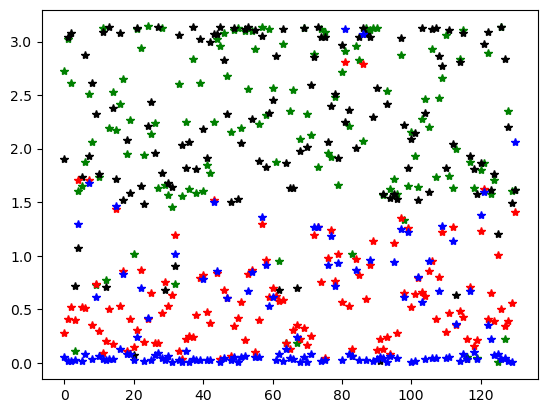

In [3]:
pos_error_icp, rot_error_icp = [], []
pos_error_icp2, rot_error_icp2 = [], []
pos_error_fcp, rot_error_fcp = [], []
pos_error_ficp, rot_error_ficp = [], []
filename_list = [name for name in os.listdir('data/meshes_coll') if name.endswith('obj')]
target_pos, target_quat = [], []
utilC = Configuration('worldPose.g', exp_name='PIFO_best', mug_inds=[0], view=False)

for filename in filename_list:
    C = ry.Config()
    C.addFile('worldPose.g')
    camera = C.cameraView()
    camera_name_list = ['camera_'+str(i) for i in range(4)]
    for camera_name in camera_name_list: 
        camera.addSensorFromFrame(camera_name)

    model = C.addMeshFrame(path.join('data/meshes_coll', filename), 'model')
    model.setPosition([-0.3,0.3,1]).setQuaternion([1,0,0,0])

    target = C.addMeshFrame(path.join('data/meshes_coll', filename), 'target')
    pos = (np.random.rand(3)-0.5)*np.array([1,1,0.2])
    pos[-1] += 1.1
    quat = np.random.randn(4)
    quat /= np.linalg.norm(quat)
    
    target.setPosition(pos).setQuaternion(quat)
    
#     target.setPosition([0.5,0.5,1.2]).setQuaternion([1,-1,2,10])
#     est = C.addMeshFrame(path.join('data/meshes_coll', filename), 'est').setColor([1,0,0]).setPosition([1,1,0])
#     V = ry.ConfigurationViewer()
#     V.setConfiguration(C)

    pc_model, pc_target = np.empty((0,3)), np.empty((0,3))
    for camera_name in camera_name_list:
        camera.selectSensor(camera_name)
        camera.updateConfig(C)
        pc_model = np.concatenate([pc_model, camera.computePointCloudOnMask('model')], axis=0)
        pc_target = np.concatenate([pc_target, camera.computePointCloudOnMask('target')], axis=0)

    ind_model= np.random.permutation(pc_model.shape[0])[:1000]
    pc_model = pc_model[ind_model]
    ind_target = np.random.permutation(pc_target.shape[0])[:1000]
    pc_target = pc_target[ind_target]

    out = get_all_images(C, camera, camera_name_list, ['model', 'target'])
    
    pifo_pc_list = []
    for i, (rgb, projection, obj_pos, obj_r) in enumerate(zip(*out[2:])):

        rgb_tensor = torch.Tensor(rgb).permute(0,3,1,2).to(utilC.device)/255.
        projection_tensor = torch.Tensor(projection).to(utilC.device)
        vertices, faces, normals = utilC.obj.extract_mesh(rgb_tensor.unsqueeze(0),  
                                                          projection_tensor.unsqueeze(0),
                                                          center=obj_pos, 
                                                          scale=obj_r*1.2,
                                                          delta=0.0,
                                                          draw=False)
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        pifo_pc_list.append(trimesh.sample.sample_surface_even(mesh,1000)[0])

    
    pifo_pc_model, pifo_pc_target = pifo_pc_list

    
    Tm = model.getAffineMatrix()
    Tt = target.getAffineMatrix()
    
    
    dT1 = ICP(pc_model, pc_target)
    dp_icp, dr_icp = SE3_distance(dT1@Tm, Tt)
    pos_error_icp.append(dp_icp)
    rot_error_icp.append(dr_icp)
    
    dT2 = ICP(pifo_pc_model, pifo_pc_target)
    dp_icp2, dr_icp2 = SE3_distance(dT2@Tm, Tt)
    pos_error_icp2.append(dp_icp2)
    rot_error_icp2.append(dr_icp2)
    
    
    dT3 = featureCP(*out[2:], utilC)
    dp_fcp, dr_fcp = SE3_distance(dT3@Tm, Tt)
    pos_error_fcp.append(dp_fcp)
    rot_error_fcp.append(dr_fcp)
    
    
    dT4 = ICP(pifo_pc_model, pifo_pc_target, dT3)
    dp_ficp, dr_ficp = SE3_distance(dT4@Tm, Tt)
    pos_error_ficp.append(dp_ficp)
    rot_error_ficp.append(dr_ficp)
    

print('ICP')
pos_error_icp, rot_error_icp = map(np.array, [pos_error_icp, rot_error_icp])
print(pos_error_icp.mean(), pos_error_icp.std())
print(rot_error_icp.mean(), rot_error_icp.std())

print('ICP2')
pos_error_icp2, rot_error_icp2 = map(np.array, [pos_error_icp2, rot_error_icp2])
print(pos_error_icp2.mean(), pos_error_icp2.std())
print(rot_error_icp2.mean(), rot_error_icp2.std())


print('FCP')
pos_error_fcp, rot_error_fcp = map(np.array, [pos_error_fcp, rot_error_fcp])
print(pos_error_fcp.mean(), pos_error_fcp.std())
print(rot_error_fcp.mean(), rot_error_fcp.std())
    
    
print('FICP')
pos_error_ficp, rot_error_ficp = map(np.array, [pos_error_ficp, rot_error_ficp])
print(pos_error_ficp.mean(), pos_error_ficp.std())
print(rot_error_ficp.mean(), rot_error_ficp.std())

plt.plot(rot_error_icp, 'g*')
plt.plot(rot_error_icp2, 'k*')
plt.plot(rot_error_fcp, 'r*')
plt.plot(rot_error_ficp, 'b*')
plt.show()

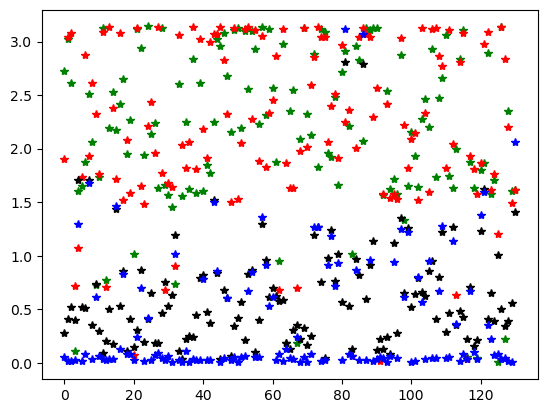

In [4]:
plt.plot(rot_error_icp, 'g*')
plt.plot(rot_error_icp2, 'r*')
plt.plot(rot_error_fcp, 'k*')
plt.plot(rot_error_ficp, 'b*')
plt.show()

with h5py.File('poseEstimation.hdf5', mode='w') as f:
    f.create_dataset('pos_error_icp', data=pos_error_icp)
    f.create_dataset('pos_error_icp2', data=pos_error_icp2)
    f.create_dataset('pos_error_fcp', data=pos_error_fcp)
    f.create_dataset('pos_error_ficp', data=pos_error_ficp)
    
    f.create_dataset('rot_error_icp', data=rot_error_icp)
    f.create_dataset('rot_error_icp2', data=rot_error_icp2)
    f.create_dataset('rot_error_fcp', data=rot_error_fcp)
    f.create_dataset('rot_error_ficp', data=rot_error_ficp)


<KeysViewHDF5 ['pos_error_fcp', 'pos_error_ficp', 'pos_error_icp', 'pos_error_icp2', 'rot_error_fcp', 'rot_error_ficp', 'rot_error_icp', 'rot_error_icp2']>


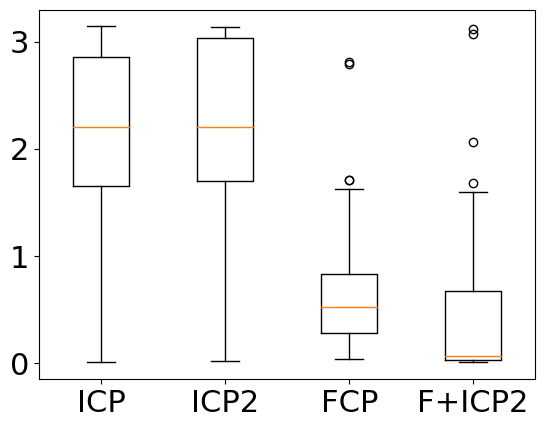

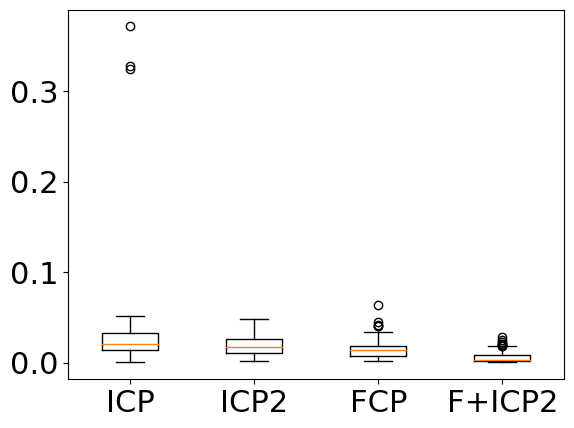

In [5]:
with h5py.File('poseEstimation.hdf5', mode='r') as f:
    print(f.keys())
    rot_error_icp, rot_error_icp2, rot_error_fcp, rot_error_ficp = f['rot_error_icp'][:], f['rot_error_icp2'][:], f['rot_error_fcp'][:], f['rot_error_ficp'][:]
    pos_error_icp, pos_error_icp2, pos_error_fcp, pos_error_ficp = f['pos_error_icp'][:], f['pos_error_icp2'][:], f['pos_error_fcp'][:], f['pos_error_ficp'][:]

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots()
ax.boxplot([rot_error_icp, rot_error_icp2, rot_error_fcp, rot_error_ficp], labels=['ICP', 'ICP2', 'FCP', 'F+ICP2'])
plt.savefig('rot_errors2.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([pos_error_icp, pos_error_icp2, pos_error_fcp, pos_error_ficp], labels=['ICP', 'ICP2', 'FCP', 'F+ICP2'])
plt.savefig('pos_errors2.pdf', bbox_inches='tight')
plt.show()

In [7]:

print('FCP')
pos_error_fcp, rot_error_fcp = map(np.array, [pos_error_fcp, rot_error_fcp])
print(pos_error_fcp.mean(), pos_error_fcp.std())
print(rot_error_fcp.mean(), rot_error_fcp.std())
    
print('ICP')
pos_error_icp, rot_error_icp = map(np.array, [pos_error_icp, rot_error_icp])
print(pos_error_icp.mean(), pos_error_icp.std())
print(rot_error_icp.mean(), rot_error_icp.std())
    
print('FICP')
pos_error_ficp, rot_error_ficp = map(np.array, [pos_error_ficp, rot_error_ficp])
print(pos_error_ficp.mean(), pos_error_ficp.std())
print(rot_error_ficp.mean(), rot_error_ficp.std())


FCP
0.018375448053627355 0.016313354520503014
0.7164516306768643 0.6140497890660612
ICP
0.020073066408794207 0.011978383377380428
2.2605154286430844 0.7528591552374777
FICP
0.009522076136163233 0.007603205644882236
0.5729535427179211 0.7846678605824046


In [ ]:
#     rgb_list = out[0]
#     mask_list = out[1]
#     rgb_focused_list = out[2]
#     num_views = len(rgb_list)
#     num_objs = len(rgb_focused_list)
#     plt.figure(figsize=(15,int(2*(num_objs+1))))
#     for i in range(num_views):   
#         plt.subplot(num_objs+1, num_views, i+1)
#         plt.imshow(rgb_list[i])

#         for j in range(num_objs):
#             plt.subplot(num_objs+1, num_views, num_views*(j+1)+i+1)
#             plt.imshow(mask_list[j][i])

#     plt.figure(figsize=(15,int(2*num_objs)))
#     for i in range(num_views):   
#         for j in range(num_objs):
#             plt.subplot(num_objs, num_views, num_views*j+i+1)
#             plt.imshow(rgb_focused_list[j][i])
#     plt.show()

In [23]:
dT1 = featureCP(*out[2:], utilC)
dT2 = ICP(pc_model, pc_target)
dT3 = ICP(pc_model, pc_target, dT1)

In [26]:
Tm = model.getAffineMatrix()
Tt = target.getAffineMatrix()
print(dT1@Tm, SE3_distance(dT1@Tm, Tt))
print(dT2@Tm, SE3_distance(dT2@Tm, Tt))
print(dT3@Tm, SE3_distance(dT3@Tm, Tt))
print(Tt)

[[-0.93552585 -0.30445277 -0.1791644   0.50661665]
 [ 0.20067186 -0.87541283  0.43975352  0.50013033]
 [-0.290727    0.37544755  0.88006644  1.20189405]
 [ 0.          0.          0.          1.        ]] (0.0068836331207162895, 0.0948044130374084)
[[ 0.54840321  0.82688756  0.1245427   0.47616246]
 [ 0.79622369 -0.4708458  -0.37991061  0.4876602 ]
 [-0.25550294  0.30750805 -0.91660081  1.2033642 ]
 [ 0.          0.          0.          1.        ]] (0.02705211695426434, 3.1239169242887304)
[[-0.95826888 -0.24582918 -0.14590664  0.50048475]
 [ 0.16416339 -0.89107014  0.42313634  0.50072859]
 [-0.23403231  0.38152587  0.89424095  1.20346651]
 [ 0.          0.          0.          1.        ]] (0.0035752686216714816, 0.03353570494893105)
[[-0.96226415 -0.22641509 -0.1509434   0.5       ]
 [ 0.1509434  -0.90566038  0.39622642  0.5       ]
 [-0.22641509  0.35849057  0.90566038  1.2       ]
 [ 0.          0.          0.          1.        ]]


In [7]:
scale_grid = [.7, 1.0]
num_grid = [5, 10]
key_points_list, features_list = [], []
for i, (rgb, projection, obj_pos, obj_r) in enumerate(zip(*out[2:])):

    
    dx = torch.linspace(-1., 1., num_grid[i]).to(utilC.device)*scale_grid[i]
    grid_x, grid_y, grid_z = torch.meshgrid(dx, dx, dx)


    rgb_tensor = torch.Tensor(rgb).permute(0,3,1,2).to(utilC.device)/255.
    projection_tensor = torch.Tensor(projection).to(utilC.device)

    key_points = torch.stack([grid_x.flatten(),
                              grid_y.flatten(),
                              grid_z.flatten()], dim=1)
    key_points *= obj_r
    key_points += torch.Tensor(obj_pos).view(1,3).to(utilC.device)

    with torch.no_grad():
        features = utilC.obj.backbone(key_points.unsqueeze(0), 
                                     rgb_tensor.unsqueeze(0), 
                                     projection_tensor.unsqueeze(0)).mean(dim=1)

    key_points_list.append(key_points.squeeze(0))
    features_list.append(features.squeeze(0))

<ipython-input-7-a89f75025704>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:208.)
  rgb_tensor = torch.Tensor(rgb).permute(0,3,1,2).to(utilC.device)/255.


In [8]:
# utilC = Configuration('worldPose.g', exp_name='PIFO_best', mug_inds=[11], view=False)
# key_points_list, features_list = utilC.extractKeyFeatures(*out[2:5], [0.1, 0.07])

crp =(features_list[0].unsqueeze(0) - features_list[1].unsqueeze(1)).norm(dim=2) # (len_target, len_model)
crp = crp.argmin(dim=0).cpu().numpy() # (len_model,)

p_model, p_target = key_points_list[0].cpu().numpy(), key_points_list[1].cpu().numpy()
R, t = poseEstimation(p_model, p_target, crp)

dT = np.eye(4)
dT[:3,:3] = R
dT[:3, 3] = t
est.setAffineMatrix(dT@model.getAffineMatrix())
V.setConfiguration(C)

In [9]:
print(est.getPosition(), est.getQuaternion())
print(target.getPosition(), target.getQuaternion())

[0.50448917 0.50000354 1.20254124] [ 0.14160774 -0.1019427   0.21476136  0.96095395]
[0.5 0.5 1.2] [ 0.09712859 -0.09712859  0.19425717  0.97128586]


In [11]:
pc_est = pc_model@R.T+t

for i in range(pc_est.shape[0]):
    C.addFrame('obj'+str(i)).setPosition(pc_est[i]).setShape(ry.ST.sphere, [0.02]).setColor([.9, .6, .6, .5])
V = ry.ConfigurationViewer()
V.setConfiguration(C)
for i in range(pc_est.shape[0]):
    C.delFrame('obj'+str(i))

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pc_est = pc_model@R.T+t
# ax.scatter(pc_model[:,0],pc_model[:,1],pc_model[:,2])
# ax.scatter(pc_est[:,0],pc_est[:,1],pc_est[:,2], c='g')
# ax.scatter(pc_target[:,0],pc_target[:,1],pc_target[:,2], c='r')
for i in range(0, crp.shape[0], 1):
    ax.plot([pc_model[i,0], pc_target[crp[i],0]], [pc_model[i,1], pc_target[crp[i],1]], [pc_model[i,2], pc_target[crp[i],2]])
plt.show()

In [83]:
crp.shape

(1100,)

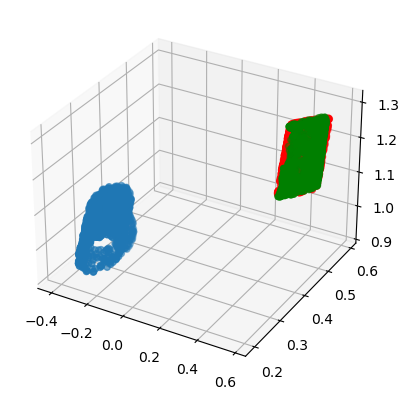

In [10]:
R, t = np.eye(3), np.zeros(3)
pc_est = pc_model@R.T+t
for _ in range(200):
    crp = np.linalg.norm(pc_est.reshape(1,-1,3) - pc_target.reshape(-1,1,3), axis=2)# (len_target, len_model)
    crp = crp.argmin(axis=0) # (len_model, )
    dR, dt = poseEstimation(pc_est, pc_target, crp)
    R = dR@R
    t = dR@t + dt
    pc_est = pc_model@R.T+t
    
    dT = np.eye(4)
    dT[:3,:3] = R
    dT[:3, 3] = t
    est.setAffineMatrix(dT@model.getAffineMatrix())
    V.setConfiguration(C)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc_model[:,0],pc_model[:,1],pc_model[:,2])
ax.scatter(pc_est[:,0],pc_est[:,1],pc_est[:,2], c='g')
ax.scatter(pc_target[:,0],pc_target[:,1],pc_target[:,2], c='r')
plt.show()

In [29]:
for i in range(pc11.shape[0]):
    C.addFrame('obj'+str(i)).setPosition(pc11[i]).setShape(ry.ST.sphere, [0.02]).setColor([.9, .6, .6, .5])
V = ry.ConfigurationViewer()
V.setConfiguration(C)
for i in range(pc11.shape[0]):
    C.delFrame('obj'+str(i))